In [1]:
#import uproot
import uproot4
from tqdm import tqdm

In [2]:
# relace next line with the path to your file
#path='data'
path='/eos/cms/store/group/phys_pps/Phase2/Delphes/PU200/ZToMuMu_M-120to200_TuneCP5_14TeV-powheg-pythia8/'
filename=path+'ZToMuMu_M-120to200_TuneCP5_14TeV-powheg-pythia8_merge.root'

In [3]:
#open the file, using uproot
root_=uproot4.open( filename )

In [4]:
#use "uproot4.concatenate":
#tree_=uproot4.concatenate([filename1+":Delphes", filename2+":Delphes"])

In [5]:
root_.keys()

['ProcessID0;1',
 'ProcessID1;1',
 'ProcessID2;1',
 'ProcessID3;1',
 'ProcessID4;1',
 'Delphes;1']

In [6]:
tree_ = root_["Delphes"]

In [7]:
vtx_size = tree_['Vertex_size'].array()

In [8]:
len(vtx_size)

100000

In [9]:
#variables_to_save=[tree_.keys()] # this will not work, due to vectors in the dataset
#muons_df = tree_.arrays(['Muon_size','Muon.PT','Muon.Eta','Muon.Phi','Muon.T'], library="pd")
#genproton_df = tree_.arrays(['GenProton_size','GenProton.Pz','GenProton.Z','GenProton.IsPU'], library="pd")
#floats_df = tree_.arrays(['GenProton.T'], library="pd")

In [10]:
import pandas as pd
import numpy as np
np.random.seed(19680801)

In [11]:
n_events = len(vtx_size)

In [12]:
#xi acceptance from Table 4 on page 40 of https://cds.cern.ch/record/2750358/files/NOTE2020_008.pdf
xi_min = 0.0095 # using the 234m station
xi_max = 0.1967 # using the 196m station
pz_min = (1-xi_max)*7000
pz_max = (1-xi_min)*7000
pz_min1 =(1-1.08*xi_max)*7000
pz_max1 =(1-0.92*xi_min)*7000
print('for xi range of (%2.3f,%2.3f) proton pz is in range from %2.2f to %2.2f GeV'%(xi_min,xi_max,pz_min,pz_max))
print(pz_min1)
print(pz_max1)

for xi range of (0.009,0.197) proton pz is in range from 5623.10 to 6933.50 GeV
5512.947999999999
6938.820000000001


In [13]:
#read protons only within the PPS acceptance
protons = tree_.arrays(['GenProton.Pz','GenProton.Z','GenProton.IsPU','GenProton.T'],  cut="(abs(GenProton.Pz)>%g) & (abs(GenProton.Pz)<%g)"%(pz_min,pz_max))

In [14]:
tr=(10**9)*50E-12
trM=(10**9)*40E-12
print(tr)
print(protons['GenProton.T'])
#print(pz)

0.05
[[1.68e-10, 4.44e-12, 1.23e-10, -1.07e-10, ... -3.18e-10, -9.12e-11, -1.35e-10]]


In [15]:
N_protons=np.zeros(len(protons)).astype(int)
genproton_pz=protons['GenProton.Pz']
genproton_vz=protons['GenProton.Z']
genproton_ispu=protons['GenProton.IsPU']
genproton_t=(10**9)*protons['GenProton.T']
genprotonpz=[]
genprotonvz=[]
genprotonispu=[]
genprotont=[]
genprotont_sm=[]
genprotonxi=[]
sig=[]


for i in tqdm(range(len(genproton_pz))):
    pz=genproton_pz[i]
    xi=1-np.abs(pz)/7000
    xi_smear=xi*(1+np.random.normal(0,0.02,len(xi)))
    pz_smear=7000*(1-xi_smear)
    t=np.zeros(len(pz))
    DPPV=np.zeros(len(pz))
    
    
    for k in range(len(pz)):
    
        if pz[k]>0:
            t[k]=(genproton_t[i][k]+(23400-genproton_vz[i][k])/30) 

        else: 
            t[k]=(genproton_t[i][k]+(23400+genproton_vz[i][k])/30) 

            
    t_smear=t+np.random.normal(0,tr,len(t))

    lpz=len(pz)
    Npr=0
    for k in range(lpz):
    
        if (abs(pz_smear[k])>pz_min) and (abs(pz_smear[k])<pz_max):
            sig.append(np.sign(pz[k]))
            genprotonpz.append(pz_smear[k])
            genprotonxi.append(xi_smear[k])
            genprotonvz.append(genproton_vz[i][k])
            genprotonispu.append(genproton_ispu[i][k])
            genprotont.append(t[k])
            genprotont_sm.append(t_smear[k])
            Npr=Npr+1
    N_protons[i]=Npr

100%|██████████| 100000/100000 [17:40<00:00, 94.33it/s]


In [16]:
N_protons[0:9]

array([ 8,  6, 12,  6, 11,  4, 11,  7,  9])

In [17]:
print(genproton_pz[0])
print(genprotonpz[0:N_protons[0]])

[6.83e+03, 6.45e+03, -6.73e+03, 6.91e+03, ... -5.8e+03, -6.88e+03, -5.78e+03]
[6827.459285086828, 6440.865461636556, 6729.245739419915, 6904.519713685738, 5678.84453348998, 5811.186673881172, 6875.925721009516, 5752.657399936436]


In [18]:
print(genprotont[0:10])
print(genprotont_sm[0:10])

[775.7398433696503, 781.4114265983403, 779.1790865748507, 778.5015669383621, 781.6259795687234, 781.2198411593607, 780.3335526265971, 781.6999519727245, 779.8554994938336, 779.8909713280779]
[775.6993761299773, 781.3495571431494, 779.2720924019725, 778.4861509765026, 781.6651280962541, 781.2209173317184, 780.369335816018, 781.7700252980551, 779.8339469594953, 779.8661053532528]


In [19]:
n_events = len(N_protons)
Prneg=np.zeros(n_events)
Prpos=np.zeros(n_events)
NmbPairs=np.zeros(n_events)

In [20]:
nprot=np.zeros(n_events)

In [ ]:
Cnt=0
for ev, nprotons in enumerate(N_protons):

    for i in range(nprotons):
        if (sig[Cnt+i]>0):
            Prpos[ev]=Prpos[ev]+1
            
        else:
            Prneg[ev]=Prneg[ev]+1

        NmbPairs=Prpos*Prneg
    Cnt=Cnt+nprotons

In [ ]:
print(Prpos)
print(Prneg)
print(NmbPairs)
sum(NmbPairs)
NPs = NmbPairs.astype(int)
print(NPs)

[3. 3. 4. ... 7. 6. 4.]
[5. 3. 8. ... 3. 4. 6.]
[15.  9. 32. ... 21. 24. 24.]
[15  9 32 ... 21 24 24]


In [23]:
N_muons=tree_['Muon_size'].array()
mu_pt=tree_['Muon.PT'].array()
mu_eta=tree_['Muon.Eta'].array()
mu_phi=tree_['Muon.Phi'].array()
mu_T=tree_['Muon.T'].array()
#mu_z=tree_['Vertex.Z'].array()

N_Tmuons=tree_['MuonTight_size'].array()
Tmu_pt=tree_['MuonTight.PT'].array()
Tmu_eta=tree_['MuonTight.Eta'].array()
Tmu_phi=tree_['MuonTight.Phi'].array()
VT=(10**9)*tree_['Vertex.T'].array()
Tmu_VT=VT+np.random.normal(0,trM,len(VT))
Tmu_Vz=tree_['Vertex.Z'].array()

In [24]:
yl=[]
ylt=[]
Tmu_T=[]
Tmu_z=[]
sumET=[]
sumTPz=[]
mll=[]
mllt=[]
TMu1_pt=[]
TMu2_pt=[]
ktm=np.zeros((len(N_Tmuons)))

for ev, nmuons in enumerate(N_Tmuons):
    Tmu1_pt=0; Tmu1_eta=0; Tmu1_phi=0; Tmu1_t=0; Tmu1_z=0
    Tmu2_pt=0; Tmu2_eta=0; Tmu2_phi=0; Tmu2_t=0; Tmu2_z=0
    for i in range(nmuons):
        if Tmu_pt[ev][i]>Tmu1_pt:
            Tmu2_pt=Tmu1_pt
            Tmu2_eta=Tmu1_eta
            Tmu2_phi=Tmu1_phi          
            
            
            Tmu1_pt=Tmu_pt[ev][i]
            Tmu1_eta=Tmu_eta[ev][i]
            Tmu1_phi=Tmu_phi[ev][i]
        elif Tmu_pt[ev][i]>Tmu2_pt:
            Tmu2_pt=Tmu_pt[ev][i]
            Tmu2_eta=Tmu_eta[ev][i]
            Tmu2_phi=Tmu_phi[ev][i]

    if (Tmu1_pt!=0) and (Tmu2_pt!=0) and (Prpos[ev]!=0) and (Prneg[ev]!=0):
        TMu1_pt.append(Tmu1_pt)
        TMu2_pt.append(Tmu2_pt)
        # compute invariant mass of lepton pair
        sumET.append(Tmu1_pt*np.cosh(Tmu1_eta)+Tmu2_pt*np.cosh(Tmu2_eta))
        sumTPx=Tmu1_pt*np.cos(Tmu1_phi)+Tmu2_pt*np.cos(Tmu2_phi)
        sumTPy=Tmu1_pt*np.sin(Tmu1_phi)+Tmu2_pt*np.sin(Tmu2_phi)
        sumTPz.append(Tmu1_pt*np.sinh(Tmu1_eta)+Tmu2_pt*np.sinh(Tmu2_eta))
            #Building the di lepton
        dTmuP=np.sqrt(sumTPx**2 + sumTPy**2 + (Tmu1_pt*np.sinh(Tmu1_eta)+Tmu2_pt*np.sinh(Tmu2_eta))**2)

        mllt2 = (Tmu1_pt*np.cosh(Tmu1_eta)+Tmu2_pt*np.cosh(Tmu2_eta))**2 - dTmuP**2  #- sumTPx**2 - sumTPy**2 - sumTPz**2
        if(mllt2<0): mllt2=0
        mllt.append(np.sqrt(mllt2))
    #    ylt[ev]=Tmu1_eta+Tmu2_eta
        Tmu_T.append(Tmu_VT[ev])
        Tmu_z.append(Tmu_Vz[ev])

        ylt.append(0.5*np.log(((Tmu1_pt*np.cosh(Tmu1_eta)+Tmu2_pt*np.cosh(Tmu2_eta))+(Tmu1_pt*np.sinh(Tmu1_eta)+Tmu2_pt*np.sinh(Tmu2_eta)))/((Tmu1_pt*np.cosh(Tmu1_eta)+Tmu2_pt*np.cosh(Tmu2_eta))-(Tmu1_pt*np.sinh(Tmu1_eta)+Tmu2_pt*np.sinh(Tmu2_eta)))))
    else:
        ktm[ev]=1

In [25]:
NP=[]
tPairs = []
t_smPairs = []
zPairs = []
xiPairs = []
nevents=len(N_protons)
Cnt=0
kt=np.zeros(nevents)
for ev in tqdm(range(nevents)):
    nprotons=N_protons[ev]
    x1=0; x2=0 ; z1=0; z2=0; t1=0; t2=0; t1sm=0; t2sm=0
    zPair = []
    t_Pair = []
    t_smPair = []
    xiPair = []

    if (ktm[ev]==0) and (Prpos[ev]!=0) and (Prneg[ev]!=0):

        for i in range(nprotons):
            if (sig[Cnt+i]>0):
                x1=genprotonxi[Cnt+i]
                z1=genprotonvz[Cnt+i]
                t1sm=genprotont_sm[Cnt+i]
                t1=genprotont[Cnt+i]
                #print(t1,genproton_t[ev][i],(23400-genproton_vz[ev][i])/30)
                for n in range (i+1,nprotons):
                    if (sig[Cnt+n]<0):
                        x2=genprotonxi[Cnt+n]
                        z2=genprotonvz[Cnt+n]
                        t2sm=genprotont_sm[Cnt+n]
                        t2=genprotont[Cnt+n]

                        xiPs=np.array([x1,x2])
                        xiPair.append(xiPs)
                        zPs=np.array([z1,z2])
                        zPair.append(zPs)
                        tPsm=np.array([t1sm,t2sm])
                        t_smPair.append(tPsm)
                        tPs=np.array([t1,t2])
                        t_Pair.append(tPs)
                    #print(0.5*30*(tPs[1]-tPs[0]),Tmu_z[ev][0])    
            elif (sig[Cnt+i]<0):
                x2=genprotonxi[Cnt+i]
                z2=genprotonvz[Cnt+i]
                t2=genprotont[Cnt+i]
                t2sm=genprotont_sm[Cnt+i]
                for n in range (i+1,nprotons):
                    if (sig[Cnt+n]>0):
                        x1=genprotonxi[Cnt+n]
                        z1=genprotonvz[Cnt+n]
                        t1sm=genprotont_sm[Cnt+n]
                        t1=genprotont[Cnt+n]

                        xiPs=np.array([x1,x2])
                        xiPair.append(xiPs)
                        zPs=np.array([z1,z2])
                        zPair.append(zPs)
                        tPsm=np.array([t1sm,t2sm])
                        t_smPair.append(tPsm)
                        tPs=np.array([t1,t2])
                        t_Pair.append(tPs)
            else:
                kt[ev]=1    #Discuss this part!!

                    #print(0.5*30*(tPs[1]-tPs[0]),Tmu_z[ev][0])
        t_smPairs.append(t_smPair)
        tPairs.append(t_Pair)
        zPairs.append(zPair)
        xiPairs.append(xiPair)
        NP.append(NPs[ev])
        Cnt=Cnt+nprotons
        
    else:
        Cnt=Cnt+nprotons

nmevents=len(mllt)
nevents=len(t_smPairs)
print(nevents)
print(nmevents)

100%|██████████| 100000/100000 [00:12<00:00, 8057.31it/s]

50812
50812


In [26]:
sum([len(x) for x in tPairs])

1240347

In [27]:
print(len(NP))

50812


In [28]:
kk=0
kkk=0
for ev in range(len(ktm)):
    if (ktm[ev]==0):
        kkk=kkk+1
    if (kt[ev]==0):
        kk=kk+1
print(kk)
print(kkk)

100000
50812


In [29]:
print(len(N_Tmuons))

100000


In [30]:
print(len(xiPairs[0]))
print(NP[0])
print(len(NP))
print(len(sumET))
print(len(sumTPz))
print(nevents)
print(len(xiPairs))
print(xiPairs[0][0][0])
print(xiPairs[0][0][1])

15
15
50812
50812
50812
50812
50812
0.02464867355902465
0.03867918008286933


In [31]:
prum=0
for ev in range(nevents):
    if (len(xiPairs[ev])==NP[ev]):
        prum=prum+1
        
print(prum)

50812


In [32]:
xiM=np.ones(nevents)
xim=np.ones(nevents)
yP=np.zeros(nevents)
mpp=np.zeros(nevents)
diff1=np.zeros(nevents)
diff2=np.zeros(nevents)

mppt=[]
mppt_sm=[]
diff1t=[]
diff2t=[]
diff1t_sm=[]
diff2t_sm=[]


for ev in range(nevents):

    for i in range(NP[ev]):

        if ((xiPairs[ev][i][0]-((sumET[ev]+sumTPz[ev])/14000))**2 + (xiPairs[ev][i][1]-((sumET[ev]-sumTPz[ev])/14000))**2) < ((xiM[ev]-((sumET[ev]+sumTPz[ev])/14000))**2 + (xim[ev]-((sumET[ev]-sumTPz[ev])/14000))**2):

            xiM[ev]=xiPairs[ev][i][0]
            xim[ev]=xiPairs[ev][i][1]
            mpp[ev]=14000.*np.sqrt(xiPairs[ev][i][0]*xiPairs[ev][i][1])
            yP[ev]=-0.5*np.log(xiM[ev]/xim[ev])
            diff1[ev]=xiPairs[ev][i][0]-((sumET[ev]+sumTPz[ev])/14000)
            diff2[ev]=xiPairs[ev][i][1]-((sumET[ev]-sumTPz[ev])/14000)


In [33]:
print(mpp)
print(diff1)
print(diff2)

[217.68461298 315.03242428 206.31125619 ... 438.93004886 179.09687409
 239.80198564]
[ 0.00286451  0.03368823 -0.0021984  ...  0.01764139  0.00508566
  0.00996451]
[0.00718913 0.00644448 0.00789935 ... 0.01943236 0.00026763 0.00453799]


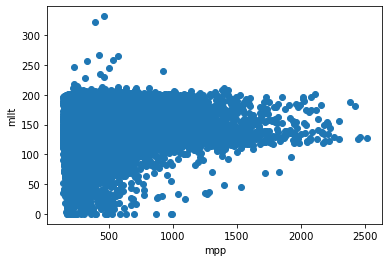

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility


plt.scatter(mpp, mllt)
plt.xlabel("mpp")
plt.ylabel("mllt")
plt.show()

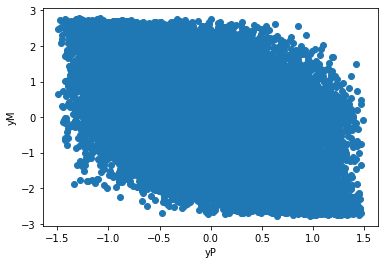

In [35]:
np.random.seed(19680801)

plt.scatter(yP, ylt)
plt.xlabel("yP")
plt.ylabel("yM")
plt.show()

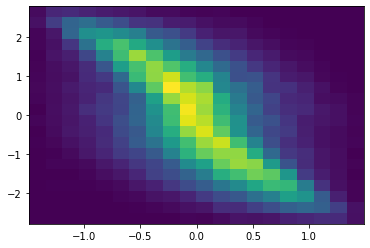

In [36]:
plt.hist2d(yP, ylt, bins=20)
plt.show()

In [37]:
import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib.colors import LogNorm

[Text(0.5, 24.0, 'DiffXi1'), Text(53.5, 0.5, 'number of entries')]

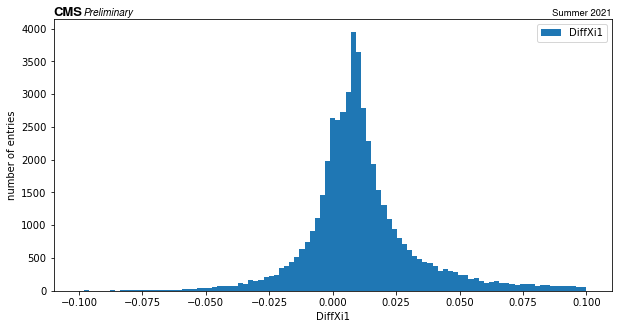

In [38]:
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(diff1, bins=np.linspace(-0.1,0.1,100),label='DiffXi1')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='DiffXi1', ylabel='number of entries')
#plt.savefig('number_muons_signal.png')

[Text(0.5, 24.0, 'DiffXi2'), Text(53.5, 0.5, 'number of entries')]

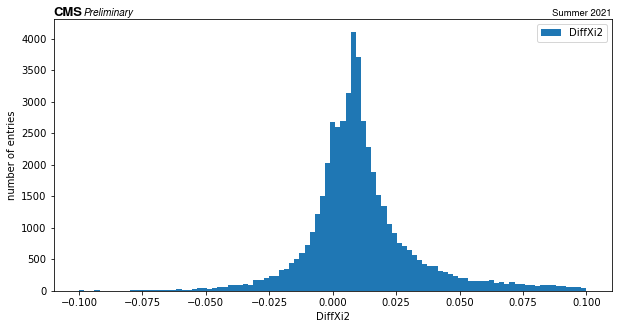

In [39]:
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(diff2, bins=np.linspace(-0.1,0.1,100),label='DiffXi2')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='DiffXi2', ylabel='number of entries')
#plt.savefig('number_muons_signal.png')
    

In [40]:
mppt=np.zeros(nevents)
mppt_sm=np.zeros(nevents)
diff1t=np.zeros(nevents)
diff2t=np.zeros(nevents)
diff1t_sm=np.zeros(nevents)
diff2t_sm=np.zeros(nevents)

xiMt=np.zeros(nevents)
ximt=np.zeros(nevents)
xiMt_sm=np.zeros(nevents)
ximt_sm=np.zeros(nevents)
tMt=np.zeros(nevents)
tmt=np.zeros(nevents)
tMt_sm=np.zeros(nevents)
tmt_sm=np.zeros(nevents)
difzT=np.zeros(nevents)-100
difzT_sm=np.zeros(nevents)-100
difzT1_sm=np.zeros(nevents)
difzT2_sm=np.zeros(nevents)
yPtsm=np.zeros(nevents)
yPt=np.zeros(nevents)
sumTs=np.zeros(nevents)

In [41]:
sumTsnsm=np.zeros(nevents)

In [42]:
NumDZT=0
c=30

for k in tqdm(range(nevents)):
    #print(k)
    if len(xiPairs[k])>0:
        xiMt[k]=xiPairs[k][0][0]
        ximt[k]=xiPairs[k][0][1]
        tMt[k]=tPairs[k][0][0]
        tmt[k]=tPairs[k][0][1]
        mppt[k]=14000.*np.sqrt(xiPairs[k][0][0]*xiPairs[k][0][1])
        diff1t[k]=xiPairs[k][0][0]-((sumET[k]+sumTPz[k])/14000)
        diff2t[k]=xiPairs[k][0][1]-((sumET[k]-sumTPz[k])/14000)
        difzT[k]=Tmu_z[k][0]-0.5*c*(tPairs[k][0][1]-tPairs[k][0][0])
        yPt[k]=-0.5*np.log(xiMt[k]/ximt[k])
        sumTsnsm[k]=(tMt[k]+tmt[k])*c-2*23400
        Dzt=[]
        for i in range (NP[k]):
            Dzt=((Tmu_z[k][0]-0.5*c*(tPairs[k][i][1]-tPairs[k][i][0])))
            #print(i,Tmu_z[k][0],0.5*c*(tPairs[k][i][1]-tPairs[k][i][0]))
            if Dzt**2 < (Tmu_z[k][0]-0.5*c*(tmt[k]-tMt[k]))**2:
                #print(k,i,Tmu_z[k][0],0.5*c*(tPairs[k][i][1]-tPairs[k][i][0]))
                xiMt[k]=xiPairs[k][i][0]
                ximt[k]=xiPairs[k][i][1]
                tMt[k]=tPairs[k][i][0]
                tmt[k]=tPairs[k][i][1]
                mppt[k]=14000.*np.sqrt(xiPairs[k][i][0]*xiPairs[k][i][1])
                diff1t[k]=xiPairs[k][i][0]-((sumET[k]+sumTPz[k])/14000)
                diff2t[k]=xiPairs[k][i][1]-((sumET[k]-sumTPz[k])/14000)
                difzT[k]=Tmu_z[k][0]-0.5*c*(tPairs[k][i][1]-tPairs[k][i][0])
                yPt[k]=-0.5*np.log(xiMt[k]/ximt[k])
                sumTsnsm[k]=(tMt[k]+tmt[k])*c-2*23400
                #print(k,Tmu_z[k][0])
                
    if difzT[k]==0:
        NumDZT=NumDZT+1
                #print(i,0.5*c*(tPairs[k][i][1]-tPairs[k][i][0]))

100%|██████████| 50812/50812 [02:02<00:00, 413.31it/s]


In [43]:
NumDZT_sm=0
NumST_sm=0
c=30

for k in tqdm(range(nevents)):
    #print(k)
    if len(xiPairs[k])>0:
        xiMt_sm[k]=xiPairs[k][0][0]
        ximt_sm[k]=xiPairs[k][0][1]        
        tMt_sm[k]=t_smPairs[k][0][0]
        tmt_sm[k]=t_smPairs[k][0][1]
        mppt_sm[k]=14000.*np.sqrt(xiPairs[k][0][0]*xiPairs[k][0][1])
        diff1t_sm[k]=xiPairs[k][0][0]-((sumET[k]+sumTPz[k])/14000)
        diff2t_sm[k]=xiPairs[k][0][1]-((sumET[k]-sumTPz[k])/14000)
        difzT_sm[k]=Tmu_z[k][0]-0.5*c*(t_smPairs[k][0][1]-t_smPairs[k][0][0])   
        Dzt=[]
        yPtsm[k]=-0.5*np.log(xiMt_sm[k]/ximt_sm[k])        
        sumTs[k]=(tMt_sm[k]+tmt_sm[k])*c-2*23400
        
        for i in range (NP[k]):
            Dzt=((Tmu_z[k][0]-0.5*c*(t_smPairs[k][i][1]-t_smPairs[k][i][0])))
            #print(i,Tmu_z[k][0],0.5*c*(tPairs[k][i][1]-tPairs[k][i][0]))
            if Dzt**2 < (Tmu_z[k][0]-0.5*c*(tmt_sm[k]-tMt_sm[k]))**2:
                #print(k,i,Tmu_z[k][0],0.5*c*(tPairs[k][i][1]-tPairs[k][i][0]))
                xiMt_sm[k]=xiPairs[k][i][0]
                ximt_sm[k]=xiPairs[k][i][1]
                tMt_sm[k]=t_smPairs[k][i][0]
                tmt_sm[k]=t_smPairs[k][i][1]
                mppt_sm[k]=14000.*np.sqrt(xiPairs[k][i][0]*xiPairs[k][i][1])
                diff1t_sm[k]=xiPairs[k][i][0]-((sumET[k]+sumTPz[k])/14000)
                diff2t_sm[k]=xiPairs[k][i][1]-((sumET[k]-sumTPz[k])/14000)
                
                yPtsm[k]=-0.5*np.log(xiMt_sm[k]/ximt_sm[k])
                
                sumTs[k]=(tMt_sm[k]+tmt_sm[k])*c-2*23400
#                difzT1_sm[k]=Tmu_T[k][0]-(t_smPairs[k][i][0]-(23400-Tmu_z[k][0])/c)
#                difzT2_sm[k]=Tmu_T[k][0]-(t_smPairs[k][i][1]-(23400-Tmu_z[k][0])/c)                
                difzT_sm[k]=Tmu_z[k][0]-0.5*c*(t_smPairs[k][i][1]-t_smPairs[k][i][0])
                #print(k,Tmu_z[k][0])
                
    if difzT_sm[k]==0:
        NumDZT_sm=NumDZT_sm+1
        
    if sumTs[k]==0:
        NumST_sm=NumST_sm+1
                #print(i,0.5*c*(tPairs[k][i][1]-tPairs[k][i][0]))

100%|██████████| 50812/50812 [02:02<00:00, 413.81it/s]


In [44]:
len(xiMt)
print(NumDZT)
print(NumDZT_sm)
print(NumST_sm)

0
0
0


[Text(0.5, 24.0, 'DiffzT'), Text(53.5, 0.5, 'number of entries')]

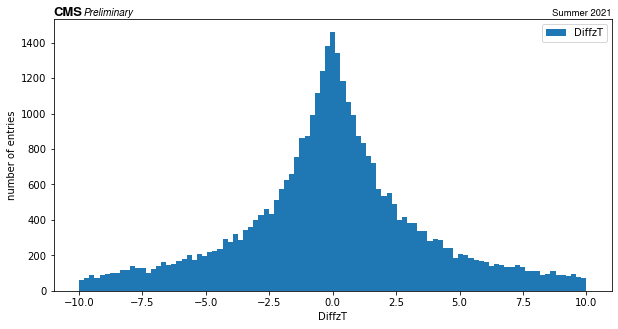

In [45]:
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(difzT, bins=np.linspace(-10,10,100),label='DiffzT')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='DiffzT', ylabel='number of entries')
#plt.savefig('VtxZ-TimeDiff XiSmear.png')

[Text(0.5, 24.0, 'DiffzT_tsmear'), Text(53.5, 0.5, 'number of entries')]

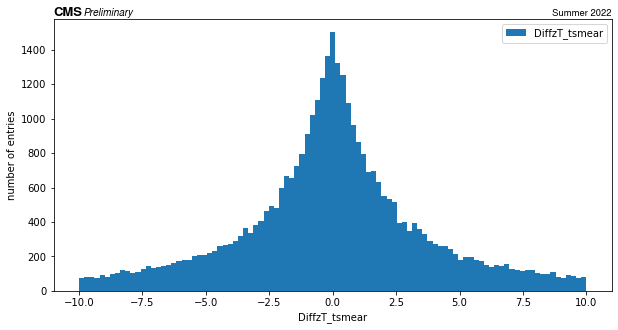

In [46]:
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(difzT_sm, bins=np.linspace(-10,10,100),label='DiffzT_tsmear')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='DiffzT_tsmear', ylabel='number of entries')
#plt.savefig('VtxZ-TimeDiff Xi&TSmear.png')

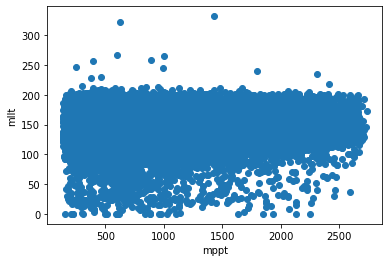

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

plt.scatter(mppt, mllt)
plt.xlabel("mppt")
plt.ylabel("mllt")
plt.show()

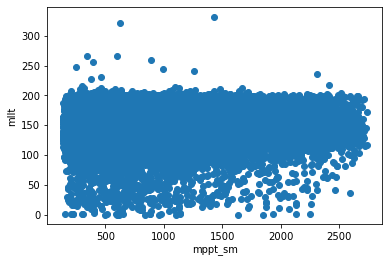

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

plt.scatter(mppt_sm, mllt)
plt.xlabel("mppt_sm")
plt.ylabel("mllt")
plt.show()

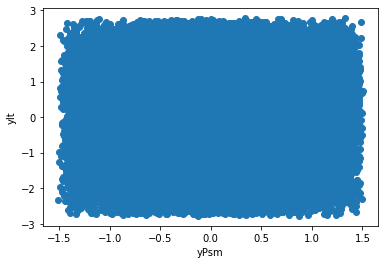

In [49]:
# Fixing random state for reproducibility
np.random.seed(19680801)

plt.scatter(yPtsm, ylt)
plt.xlabel("yPsm")
plt.ylabel("ylt")
plt.show()

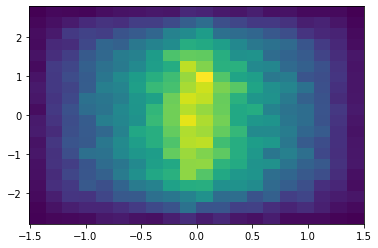

In [50]:
plt.hist2d(yPtsm, ylt, bins=20)
plt.show()

In [51]:
print(xiM)
print(xim)
print(xiMt)
print(ximt)

[0.01364004 0.04771511 0.01914066 ... 0.04364642 0.01099323 0.01979684]
[0.0177249  0.01061203 0.01134574 ... 0.02252091 0.01488657 0.01482019]
[0.07987636 0.18756065 0.01914066 ... 0.04594316 0.01290134 0.01979684]
[0.03867918 0.04246001 0.14034829 ... 0.06322182 0.01488657 0.09945069]


In [52]:
print(len(xiM))
print(len(xiMt))

50812
50812


In [53]:
XIM=np.zeros(nevents)
XIm=np.zeros(nevents)
TMt=np.zeros(nevents)
Tmt=np.zeros(nevents)

numnz=0
XIMnsm=np.zeros(nevents)
XImnsm=np.zeros(nevents)
numnznsm=0

In [54]:
TMtnsm=np.zeros(nevents)
Tmtnsm=np.zeros(nevents)

In [55]:
for i in tqdm(range(nevents)):
    #print(k)
    if xiM[i]==xiMt_sm[i] and xim[i]==ximt_sm[i]:
        XIM[i]=xiM[i]
        XIm[i]=xim[i]
        TMt[i]=tMt_sm[i]
        Tmt[i]=tmt_sm[i]
        numnz=numnz+1

100%|██████████| 50812/50812 [00:00<00:00, 709497.46it/s]


In [56]:
for i in tqdm(range(nevents)):
    #print(k)
    if xiM[i]==xiMt[i] and xim[i]==ximt[i]:
        XIMnsm[i]=xiM[i]
        XImnsm[i]=xim[i]
        TMtnsm[i]=tMt[i]
        Tmtnsm[i]=tmt[i]
        numnznsm=numnznsm+1

100%|██████████| 50812/50812 [00:00<00:00, 1638497.24it/s]


In [57]:
print(XIM)
print(numnz)
print(XIMnsm)
print(numnznsm)

[0. 0. 0. ... 0. 0. 0.]
3641
[0. 0. 0. ... 0. 0. 0.]
3617


In [58]:
MPP=[]
MLL=[]
M=[]
YPP=[]
YLL=[]
Y=[]
CTDif=[]
Muz=[]
Mut=[]
ST=[]

for i in range (nevents):
    if (XIM[i]!=0) and (TMu2_pt[i]>0):
        MPP.append(14000.*np.sqrt(XIM[i]*XIm[i]))
        MLL.append(mllt[i])
        YPP.append(0.5*np.log(XIM[i]/XIm[i]))
        YLL.append(ylt[i])
        CTDif.append(0.5*c*(TMt[i]-Tmt[i]))
        Muz.append(Tmu_z[i][0])
        Mut.append(Tmu_T[i][0])
        ST.append((0.5*sumTs[i])/c)
    
print(len(MPP)/10000)
for i in range (len(MPP)):
    M.append((MPP[i]-MLL[i])/(MPP[i]+MLL[i]))
    Y.append((YPP[i]-YLL[i])) #/(YPP[i]+YLL[i]))


MPPnsm=[]
MLLnsm=[]
Mnsm=[]
YPPnsm=[]
YLLnsm=[]
Ynsm=[]
CTDifnsm=[]
Muznsm=[]
Mutnsm=[]
STnsm=[]
for i in range (nevents):
    if (XIMnsm[i]!=0) and (TMu2_pt[i]>0):
        MPPnsm.append(14000.*np.sqrt(XIMnsm[i]*XImnsm[i]))
        MLLnsm.append(mllt[i])
        CTDifnsm.append(0.5*c*(TMtnsm[i]-Tmtnsm[i]))
        Muznsm.append(Tmu_z[i][0])
        Mutnsm.append(Tmu_T[i][0])
        STnsm.append((0.5*sumTsnsm[i])/c)
print(len(MPPnsm)/10000)
for i in range (len(MPPnsm)):
    Mnsm.append((MPPnsm[i]-MLLnsm[i])/(MPPnsm[i]+MLLnsm[i]))



0.3641
0.3617


In [59]:
print(sumTs[0:500])

[ 1.86494864e+01 -8.75415244e+01  3.27716885e+01 -1.59512290e+01
  1.10459218e+02  3.97121174e-01  3.18248997e+01 -3.22973163e+01
  8.02411206e+01 -2.87028001e+01 -5.37515744e+01 -3.62966714e+01
 -2.70776050e+01 -3.06218951e+01 -9.17059787e+01 -7.24394556e+01
  5.91516434e+01  1.55558915e+02  4.65074921e+00  6.19720278e+01
  8.60293650e+00 -9.78241120e+01 -7.92823209e+01  5.17958921e+01
 -3.35909993e+01 -5.19896865e+01  2.94562433e+01 -9.82536646e+01
  1.05729822e+02  4.77943383e+01 -3.51345121e+01 -4.75374488e+01
  6.49797458e+01 -2.34539962e+01 -4.59176325e+01 -8.05874359e+01
 -8.22564237e+01 -2.57247347e+01 -7.30458653e+01  8.75059498e+01
 -1.34436861e+02 -5.40995588e+01  1.01326892e+02 -7.87755219e+01
 -6.58868730e+01  4.28526766e+01  1.39335568e+02 -7.76929307e+01
 -1.29658528e+02 -6.60750704e+01 -8.28738089e+01 -1.08861821e+02
  6.04689228e+01  6.22367465e+01 -2.83120200e+01 -2.96402253e+01
 -1.48387195e+00  6.80440457e+01  9.17107622e+00 -7.67750673e+01
 -1.78655170e+01  5.99835

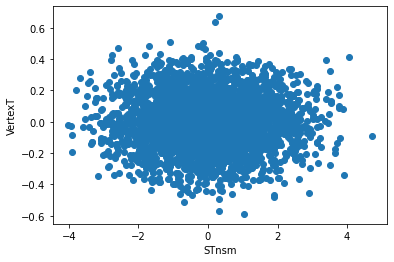

In [60]:
np.random.seed(19680801)

plt.scatter(STnsm,Mutnsm)
plt.xlabel("STnsm")
plt.ylabel("VertexT")
plt.show()

In [61]:
len(MLL)

3641

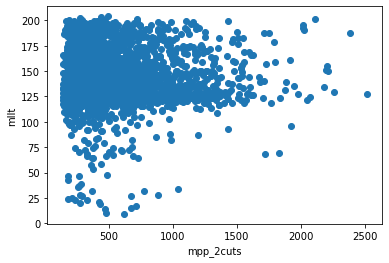

In [62]:
import matplotlib.pyplot as plt 
import numpy as np

#Smeared
np.random.seed(19680801)

plt.scatter(MPP,MLL)
plt.xlabel("mpp_2cuts")
plt.ylabel("mllt")
plt.show()

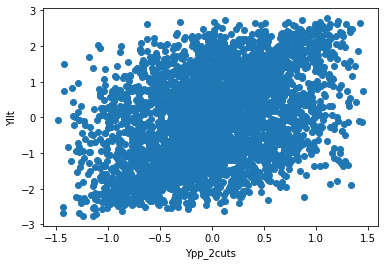

In [63]:
np.random.seed(19680801)

plt.scatter(YPP,YLL)
plt.xlabel("Ypp_2cuts")
plt.ylabel("Yllt")
plt.show()

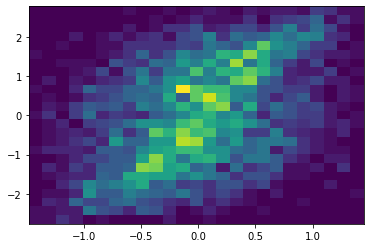

In [64]:
plt.hist2d(YPP, YLL, bins=25)
plt.show()

[Text(0.5, 33.0, 'Ypp-Yll'), Text(59.875, 0.5, 'number of entries')]

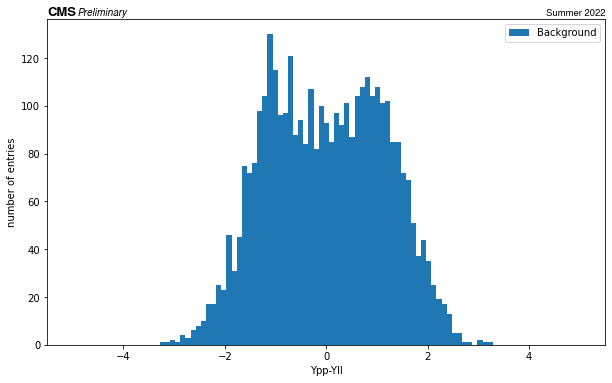

In [65]:
f, ax = plt.subplots(figsize=(10,6))
plt.hist(Y, bins=np.linspace(-5,5,100),label='Background')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='Ypp-Yll', ylabel='number of entries')

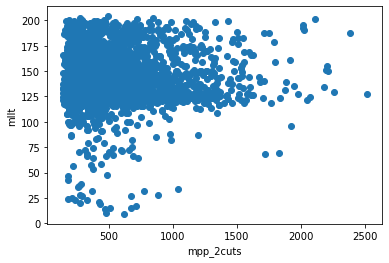

In [66]:
import matplotlib.pyplot as plt
import numpy as np

#Un Smeared
np.random.seed(19680801)

plt.scatter(MPPnsm,MLLnsm)
plt.xlabel("mpp_2cuts")
plt.ylabel("mllt")
plt.show()

[Text(0.5, 33.0, 'Mpp-Mll'), Text(59.875, 0.5, 'number of entries')]

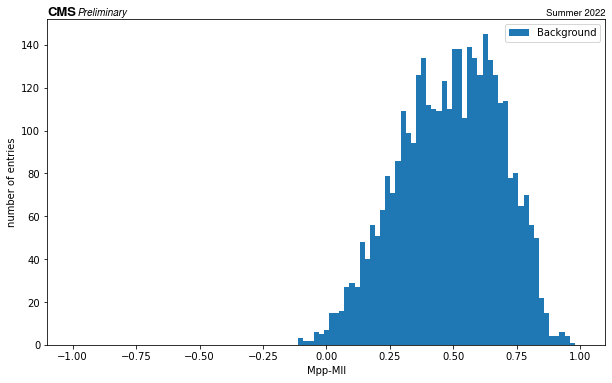

In [67]:
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,6))
plt.hist(M, bins=np.linspace(-1,1,100),label='Background')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='Mpp-Mll', ylabel='number of entries')
#plt.savefig('InvariantMassCorrBothSmearing.png')

[Text(0.5, 24.0, 'MPP-MLL'), Text(59.875, 0.5, 'number of entries')]

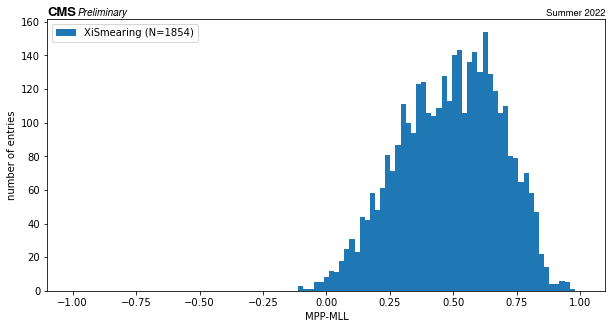

In [68]:
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(Mnsm, bins=np.linspace(-1,1,100),label='XiSmearing (N=1854)')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='MPP-MLL', ylabel='number of entries')
#plt.savefig('InvariantMassCorrXiSmearings.png')

In [69]:
len(M)

3641

In [70]:
kt=0
for i in range (len(M)):
    if np.abs(M[i])<0.025:
        kt=kt+1
print(kt)
Lum=300e15
Cross=18.72e-12
Acc=kt/n_events
NumbEv=Lum*Cross*Acc
print(NumbEv)

23
1291.68


In [71]:
ktnsm=0
for i in range (len(Mnsm)):
    if np.abs(Mnsm[i])<0.025:
        ktnsm=ktnsm+1
print(ktnsm)
Lum=300e15
Cross=18.72e-12
Accnsm=ktnsm/n_events
NumbEvnsm=Lum*Cross*Accnsm
print(NumbEvnsm)

22
1235.52


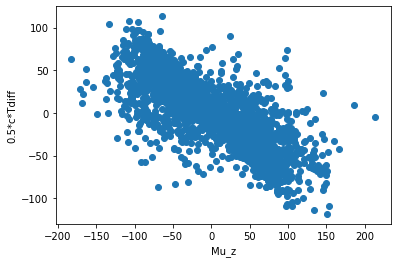

In [72]:
np.random.seed(19680801)

plt.scatter(Muz,CTDif)
plt.xlabel("Mu_z")
plt.ylabel("0.5*c*Tdiff")
plt.show()

In [73]:
#Clean the events
#Plot with density


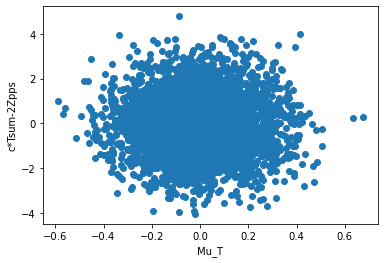

In [74]:
np.random.seed(19680801)

plt.scatter(Mut,ST)
plt.xlabel("Mu_T")
plt.ylabel("c*Tsum-2Zpps")
#plt.ylim([-1,1])
plt.show()

In [75]:
D=np.zeros(len(Mut))
DD=np.zeros(len(Mut))

for ev in range(len(Mut)):

    D[ev]=Mut[ev]-ST[ev]
    DD[ev]=Muz[ev]+CTDif[ev]

No handles with labels found to put in legend.


[Text(0.5, 33.0, 'Vertex time difference'),
 Text(59.875, 0.5, 'number of entries')]

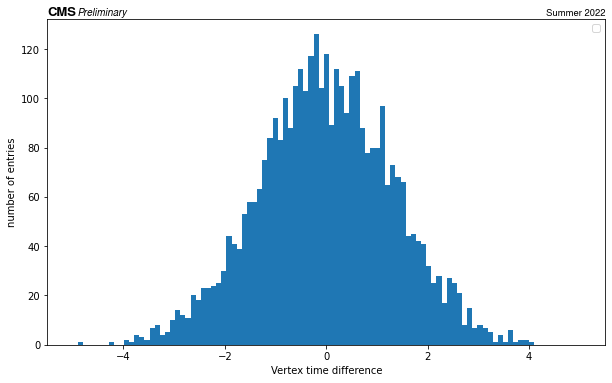

In [76]:
f, ax = plt.subplots(figsize=(10,6))
plt.hist(D, bins=np.linspace(-5,5,100),label='')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='Vertex time difference', ylabel='number of entries')
#plt.savefig('InvariantMassCorrBothSmearings.png')

No handles with labels found to put in legend.


[Text(0.5, 33.0, 'Vertex Z difference'), Text(66.25, 0.5, 'number of entries')]

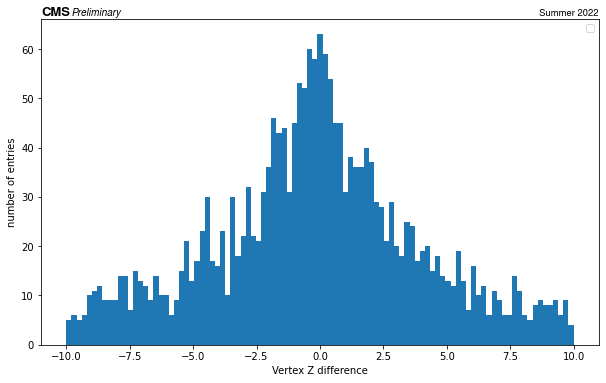

In [77]:
f, ax = plt.subplots(figsize=(10,6))
plt.hist(DD, bins=np.linspace(-10,10,100),label='')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='Vertex Z difference', ylabel='number of entries')
#plt.savefig('InvariantMassCorrBothSmearings.png')

In [78]:
kt=0
for i in range (len(M)):
    if (np.abs(M[i])<0.025):
        kt=kt+1
print(kt)
Lum=300e15
Cross=18.72e-12
Acc=kt/n_events
NumbEv=Lum*Cross*Acc
print(NumbEv)

23
1291.68


In [79]:
kt=0
for i in range (len(M)):
    if (np.abs(Y[i])<0.05):
        kt=kt+1
print(kt)
Lum=300e15
Cross=18.72e-12
Acc=kt/n_events
NumbEv=Lum*Cross*Acc
print(NumbEv)

90
5054.4


In [80]:
kt=0
for i in range (len(M)):
    if (np.abs(D[i])<0.25):
        kt=kt+1
print(kt)
Lum=300e15
Cross=18.72e-12
Acc=kt/n_events
NumbEv=Lum*Cross*Acc
print(NumbEv)

543
30494.88


In [81]:
kt=0
for i in range (len(M)):
    if (np.abs(DD[i])<1.5):
        kt=kt+1
print(kt)
Lum=300e15
Cross=18.72e-12
Acc=kt/n_events
NumbEv=Lum*Cross*Acc
print(NumbEv)

709
39817.44


In [82]:
kt=0
for i in range (len(M)):
    if (np.abs(M[i])<0.025) and (np.abs(Y[i])<0.05):
        kt=kt+1
print(kt)
Lum=300e15
Cross=18.72e-12
Acc=kt/n_events
NumbEv=Lum*Cross*Acc
print(NumbEv)

2
112.32000000000001


In [83]:
kt=0
for i in range (len(M)):
    if (np.abs(M[i])<0.025) and (np.abs(D[i])<0.25):
        kt=kt+1
print(kt)
Lum=300e15
Cross=18.72e-12
Acc=kt/n_events
NumbEv=Lum*Cross*Acc
print(NumbEv)

5
280.8


In [84]:
kt=0
for i in range (len(M)):
    if (np.abs(Y[i])<0.05) and (np.abs(D[i])<0.25):
        kt=kt+1
print(kt)
Lum=300e15
Cross=18.72e-12
Acc=kt/n_events
NumbEv=Lum*Cross*Acc
print(NumbEv)

12
673.9200000000001


In [85]:
kt=0
for i in range (len(M)):
    if (np.abs(M[i])<0.025) and (np.abs(Y[i])<0.05) and (np.abs(D[i])<0.25):
        kt=kt+1
print(kt)
Lum=300e15
Cross=18.72e-12
Acc=kt/n_events
NumbEv=Lum*Cross*Acc
print(NumbEv)

0
0.0


In [86]:
print(Lum*Cross/n_events)

56.16


In [87]:
n_events

100000

In [88]:
#(tMt_sm[k]+tmt_sm[k])*c-2*23400

In [89]:
#            t[k]=(genproton_t[i][k]+(23400-genproton_vz[i][k])/30) 

#        else: 
#            t[k]=(genproton_t[i][k]+(23400+genproton_vz[i][k])/30) 

#Doing the table with the values with bkg
#Changing the smearing values
#Statistical discussion about the number of events in the BKG